In [1]:
import pandas as pd
import numpy as np

import scipy
from scipy import stats
import statsmodels as sm
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


from datetime import datetime
import time
import datetime

import eikon as ek
#creds = 'f5a341b614d945b9b93a71fe53348ba119d11e99'
#API Key Lionel: d505f265d9bd4c0cb7df44481ece31a0ad8d1974
#API Key Raphi: f5a341b614d945b9b93a71fe53348ba119d11e99
#API Key Laurin:
ek.set_app_key('d505f265d9bd4c0cb7df44481ece31a0ad8d1974')

GDP nicht nehmen, da nur Quartal / unemployment rate / Inflation (CPI) / purchasing manager index (PMI)

US / Eurozone / CH / China

In [2]:
Makro_Data = ['USUNR=ECI',  #US Unemploymet
              'USCPI=ECI',  #US CPI
              'USPMI=ECI',  #US PMI
              'EUUNR=ECI',  #EU Unemployment
              'EUHICY=ECI', #EU CPI
              'EUPMI=ECI',  #EU PMI                NICHT GUT (Nicht vollständig)
              'CHJOB=ECI',  #CH Unemployment
              'CHCPIY=ECI', #CH CPI
              'CHPMI=ECI',  #CH PMI
            #China is in the Dataset due to its exposure to the Metals
              'CNURUA=ECI', #China Unemployment    NICHT GUT (Nicht vollständig)
              'CNCPI=ECI',   #China CPI
              'CNPMIB=ECI',  #China PMI
            #Russia is in the Dataset due to its exporsure to Oil & Gas
              'RUUNR=ECI',  #Russia Unemployment
              'RUCPIY=ECI', #Russia CPI
              'RUPMIM=ECI', #Russia PMI            NICHT GUT (Nicht vollständig)
             ]  

In [3]:
macro = ek.get_timeseries(Makro_Data,
                          start_date='2012-01-01',
                          end_date='2022-01-01',
                          fields='VALUE',
                          interval='monthly')                      

In [4]:
macro.isnull().sum()

VALUE
USUNR=ECI      0
USCPI=ECI      0
USPMI=ECI      0
EUUNR=ECI      0
EUHICY=ECI     0
EUPMI=ECI     71
CHJOB=ECI      0
CHCPIY=ECI     0
CHPMI=ECI      0
CNURUA=ECI    68
CNCPI=ECI      0
CNPMIB=ECI     0
RUUNR=ECI      0
RUCPIY=ECI     0
RUPMIM=ECI    87
dtype: int64

In [5]:
macro.describe()

VALUE,USUNR=ECI,USCPI=ECI,USPMI=ECI,EUUNR=ECI,EUHICY=ECI,EUPMI=ECI,CHJOB=ECI,CHCPIY=ECI,CHPMI=ECI,CNURUA=ECI,CNCPI=ECI,CNPMIB=ECI,RUUNR=ECI,RUCPIY=ECI,RUPMIM=ECI
count,120.000000,120.000000,120.000000,120.000000,120.000000,49.000000,120.00000,120.000000,120.000000,52.000000,120.000000,120.00000,120.000000,120.000000,33.000000
mean,5.711667,0.177500,54.350000,9.708333,1.204167,52.934694,2.96500,-0.084167,54.200000,5.186538,2.072500,50.51250,5.241667,6.340000,48.203030
std,1.944662,0.254526,4.152755,1.723909,1.035617,6.465374,0.34584,0.729452,6.589041,0.317483,0.983474,1.59698,0.525738,3.622395,4.202342
min,3.500000,-0.800000,41.600000,7.000000,-0.600000,33.400000,2.30000,-1.400000,40.700000,4.800000,-0.500000,35.70000,4.300000,2.200000,31.300000
25%,4.200000,0.000000,51.250000,8.100000,0.400000,47.700000,2.80000,-0.600000,49.200000,5.000000,1.500000,50.10000,4.900000,3.775000,47.500000
50%,5.150000,0.200000,54.400000,9.650000,1.200000,53.700000,3.10000,-0.100000,53.700000,5.100000,2.000000,50.50000,5.200000,5.800000,49.100000
75%,6.750000,0.300000,57.625000,11.500000,1.900000,58.000000,3.20000,0.600000,58.300000,5.300000,2.500000,51.22500,5.600000,7.300000,50.900000
max,14.700000,0.900000,63.700000,12.200000,5.000000,63.400000,3.50000,1.500000,70.000000,6.200000,5.400000,53.30000,6.400000,16.900000,51.900000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025D9CD53C70>,
      dtype=object)

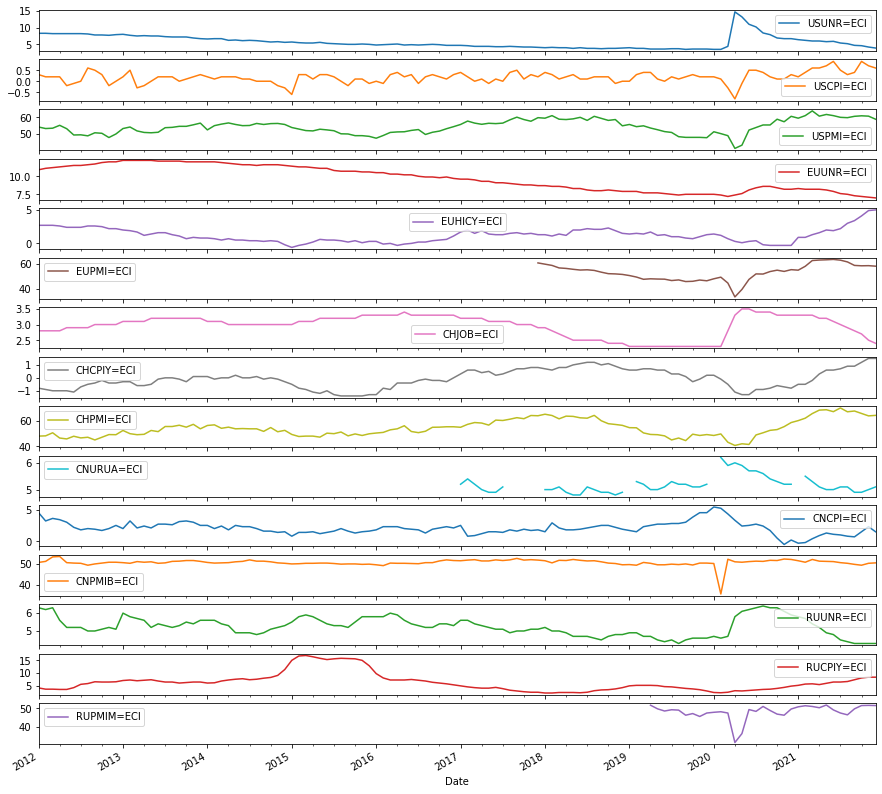

In [6]:
macro.plot(subplots=True, figsize=(15,15))

In [7]:
macro2 = macro
macro2.columns = macro2.columns.str.replace("=", "_")
macro2 = macro2.unstack()
macro2 = macro2.reset_index()
macro2 = macro2.rename(columns={'VALUE': 'Macro_Variable', 0: 'Value'})
macro2['Date'] = pd.to_datetime(macro2['Date']).dt.date
liste_SQL = macro2.values.tolist()
macro2.head(5)

,Macro_Variable,Date,Value
0,USUNR_ECI,2012-01-31,8.3
1,USUNR_ECI,2012-02-29,8.3
2,USUNR_ECI,2012-03-31,8.2
3,USUNR_ECI,2012-04-30,8.2
4,USUNR_ECI,2012-05-31,8.2


In [8]:
import sqlite3
from sqlite3 import Error
 
""" create a database connection tool to a SQLite database """
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

if __name__ == '__main__':
    create_connection(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")

2.6.0


In [9]:
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute('''DROP TABLE IF EXISTS MACRO_DATA;''')

In [10]:
conn = sqlite3.connect('SQL_DB.db')
c = conn.cursor()
c.execute('''CREATE TABLE MACRO_DATA (
    "Macro_Variable" TEXT,
    DATE DATETIME,
	"Value" NUMERIC
);''')


In [11]:
conn = sqlite3.connect(r"C:\Users\lione\OneDrive\Dokumente\GitHub\AQM\SQL_DB.db")
#Add all Data at once:
c = conn.cursor()
c.executemany("INSERT INTO MACRO_DATA(Macro_Variable, DATE, Value) VALUES (?,?,?)", liste_SQL)    
conn.commit()

In [12]:
#Select Data from SQL DB:   
c = conn.cursor()
c.execute("SELECT * FROM MACRO_DATA")
new_data=c.fetchall()
ref_data = pd.DataFrame(new_data,columns=['Macro_Variable', 'DATE', 'Value'])
ref_data = ref_data.set_index('DATE')
ref_data

,Macro_Variable,Value
DATE,,
2012-01-31,USUNR_ECI,8.3
2012-02-29,USUNR_ECI,8.3
2012-03-31,USUNR_ECI,8.2
2012-04-30,USUNR_ECI,8.2
2012-05-31,USUNR_ECI,8.2
...,...,...
2021-08-31,RUPMIM_ECI,46.5
2021-09-30,RUPMIM_ECI,49.8
2021-10-31,RUPMIM_ECI,51.6


In [13]:
macro_data = ref_data.pivot(columns='Macro_Variable', values=['Value'])
macro_data.to_excel('Macro_Data_from_SQL.xlsx')
macro_data

Value                                                      \
Macro_Variable CHCPIY_ECI CHJOB_ECI CHPMI_ECI CNCPI_ECI CNPMIB_ECI CNURUA_ECI   
DATE                                                                            
2012-01-31           -0.8       2.8      48.0       4.5       50.5        NaN   
2012-02-29           -0.9       2.8      48.2       3.2       51.0        NaN   
2012-03-31           -1.0       2.8      50.6       3.6       53.1        NaN   
2012-04-30           -1.0       2.8      46.5       3.4       53.3        NaN   
2012-05-31           -1.0       2.9      45.8       3.0       50.4        NaN   
...                   ...       ...       ...       ...        ...        ...   
2021-08-31            0.9       2.9      67.0       0.8       50.1        5.1   
2021-09-30            0.9       2.8      67.6       0.7       49.6        4.9   
2021-10-31            1.2       2.7      65.7       1.5       49.2        4.9   
2021-11-30            1.5       2.5      63.8       2.3       50.1        5.0   
2021-12-31            1.5       2.4      64.2       1.5       50.3        5.1   

                                                                               \
Macro_Variable EUHICY_ECI EUPMI_ECI EUUNR_ECI RUCPIY_ECI RUPMIM_ECI RUUNR_ECI   
DATE                                                                            
2012-01-31            2.7       NaN      10.9        4.2        NaN       6.3   
2012-02-29            2.7       NaN      11.1        3.7        NaN       6.2   
2012-03-31            2.7       NaN      11.2        3.7        NaN       6.3   
2012-04-30            2.6       NaN      11.3        3.6        NaN       5.6   
2012-05-31            2.4       NaN      11.4        3.6        NaN       5.2   
...                   ...       ...       ...        ...        ...       ...   
2021-08-31            3.0      61.4       7.5        6.7       46.5       4.4   
2021-09-30            3.4      58.6       7.3        7.4       49.8       4.3   
2021-10-31            4.1      58.3       7.2        8.1       51.6       4.3   
2021-11-30            4.9      58.4       7.1        8.4       51.7       4.3   
2021-12-31            5.0      58.0       7.0        8.4       51.6       4.3   

                                              
Macro_Variable USCPI_ECI USPMI_ECI USUNR_ECI  
DATE                                          
2012-01-31           0.3      54.2       8.3  
2012-02-29           0.2      53.3       8.3  
2012-03-31           0.2      53.5       8.2  
2012-04-30           0.2      55.2       8.2  
2012-05-31          -0.2      53.2       8.2  
...                  ...       ...       ...  
2021-08-31           0.3      59.7       5.2  
2021-09-30           0.4      60.5       4.7  
2021-10-31           0.9      60.8       4.6  
2021-11-30           0.7      60.6       4.2  
2021-12-31           0.6      58.8       3.9  

[120 rows x 15 columns]